In [18]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [19]:
directory = 'images'

files = os.listdir(directory)

In [25]:
x_train=[]
x_test=[]

y_train=[]
y_test=[]

for i in range(0,100):
    added=[]
    img = Image.open(directory+'\\'+files[i])
    img=img.resize((28,28))
    for i0 in range(28):
        for i1 in range(28):
            added.append(img.getpixel((i1,i0)))
    x_train.append([added])
    y_train.append(1)

for i in range(101,150):
    added=[]
    img = Image.open(directory+'\\'+files[i])
    img=img.resize((28,28))
    for i0 in range(28):
        for i1 in range(28):
            added.append(img.getpixel((i1,i0)))
    x_test.append([added])
    y_test.append(1)


x_train=np.array(x_train)
x_test=np.array(x_test)

y_train=np.array(y_train)
y_test=np.array(y_test)

x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 3))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 3))

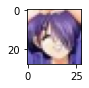

In [27]:
plt.figure(figsize=(1,1))
plt.imshow(x_train[0, :, :, :])
plt.show()